# 04_ab_analysis.ipynb - A/B аналіз push-груп

## 🏷️ Аналіз ефективності A/B груп push-сповіщень

Цей ноутбук аналізує ефективність різних A/B груп push-сповіщень та їх вплив на депозити Android-користувачів.

### Вхідні дані:
- **6 A/B груп** (1, 2, 3, 4, 5, 6)
- **3,219,484 користувачів** загалом
- **41,193 користувачів з депозитами** (1.28%)
- **$226,815 загального доходу**

### Ключові питання:
1. Яка A/B група найефективніша?
2. Чи є статистично значуща різниця між групами?
3. Як кількість push-ів впливає на конверсію?
4. Які рекомендації для оптимізації?

---

In [33]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# Статистичні тести
from scipy import stats
from scipy.stats import chi2_contingency, mannwhitneyu, kruskal
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests
from sklearn.utils import resample

import warnings
warnings.filterwarnings('ignore')

# Налаштування візуалізації
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("🏷️ A/B АНАЛІЗ PUSH-ГРУП")
print("=" * 50)
print(f"🎯 Мета: Визначити найефективнішу A/B групу")
print(f"📊 Метрики: Конверсія, дохід, статистична значущість")

🏷️ A/B АНАЛІЗ PUSH-ГРУП
🎯 Мета: Визначити найефективнішу A/B групу
📊 Метрики: Конверсія, дохід, статистична значущість


## **КРОК 1: Завантаження готових даних для A/B аналізу**

In [34]:
print("\n🔗 КРОК 1: ЗАВАНТАЖЕННЯ ДАНИХ ДЛЯ A/B АНАЛІЗУ")
print("-" * 40)

# Завантажуємо готові дані
try:
    ab_df = pd.read_parquet('../data/processed/ab_analysis_ready.parquet')
    print(f"✅ Дані завантажено: {len(ab_df):,} записів")
except FileNotFoundError:
    print("❌ Файл ab_analysis_ready.parquet не знайдено")
    print("💡 Запустіть спочатку 03_data_matching.ipynb")
    raise

print(f"📊 Колонки: {list(ab_df.columns)}")
print(f"📏 Розмір датасету: {ab_df.shape}")

# Базова інформація
print("\n📈 БАЗОВА СТАТИСТИКА:")
print(f"   👥 Загалом користувачів: {len(ab_df):,}")
print(f"   📱 Загалом push-ів: {ab_df['total_pushes'].sum():,}")
print(f"   💰 Користувачі з депозитами: {ab_df['has_deposit'].sum():,}")
print(f"   💵 Загальний дохід: ${ab_df['total_revenue'].sum():,.2f}")

# A/B групи
print(f"\n🏷️ A/B ГРУПИ:")
group_counts = ab_df['ab_group'].value_counts().sort_index()
for group, count in group_counts.items():
    pct = count / len(ab_df) * 100
    print(f"   Група {group}: {count:,} користувачів ({pct:.1f}%)")

# Перевіряємо чи є дані по tier
if 'tier' in ab_df.columns:
    print(f"\n🌍 РОЗПОДІЛ ПО TIER:")
    tier_counts = ab_df['tier'].value_counts()
    for tier, count in tier_counts.head().items():
        print(f"   {tier}: {count:,} користувачів")

# Показуємо приклад
print("\n🔍 ПРИКЛАД ДАНИХ:")
display(ab_df.head())


🔗 КРОК 1: ЗАВАНТАЖЕННЯ ДАНИХ ДЛЯ A/B АНАЛІЗУ
----------------------------------------
✅ Дані завантажено: 3,219,484 записів
📊 Колонки: ['gadid', 'ab_group', 'total_pushes', 'has_deposit', 'has_registration', 'total_revenue', 'tier_final', 'user_category', 'push_segment']
📏 Розмір датасету: (3219484, 9)

📈 БАЗОВА СТАТИСТИКА:
   👥 Загалом користувачів: 3,219,484
   📱 Загалом push-ів: 361,999,359
   💰 Користувачі з депозитами: 41,193
   💵 Загальний дохід: $226,815.28

🏷️ A/B ГРУПИ:
   Група 1: 643,636 користувачів (20.0%)
   Група 2: 644,463 користувачів (20.0%)
   Група 3: 643,002 користувачів (20.0%)
   Група 4: 642,431 користувачів (20.0%)
   Група 5: 645,896 користувачів (20.1%)
   Група 6: 56 користувачів (0.0%)

🔍 ПРИКЛАД ДАНИХ:


,gadid,ab_group,total_pushes,has_deposit,has_registration,total_revenue,tier_final,user_category,push_segment
0,00000000-0000-0000-0000-000000000000,5,339118,1,1,0.0,Unknown,Depositor,50+
1,00000000-0000-0000-0000-000000000000,5,339118,1,1,0.0,Unknown,Depositor,50+
2,00000000-0000-0000-0000-000000000000,5,339118,1,1,0.0,Unknown,Depositor,50+
3,00000000-0000-0000-0000-000000000000,5,339118,1,1,0.0,Unknown,Depositor,50+
4,00000000-0000-0000-0000-000000000000,5,339118,1,1,0.0,Unknown,Depositor,50+


## **КРОК 2: Базовий A/B аналіз по групах**


🔗 КРОК 2: БАЗОВИЙ A/B АНАЛІЗ
----------------------------------------
💡 ВАЖЛИВО: Кожна A/B група тестує певну частоту push-сповіщень на день!
⚠️ Припускаємо тривалість кампанії 7 днів для розрахунку pushes_per_day

📊 ЗАГАЛЬНА СТАТИСТИКА ПО A/B ГРУПАХ:
          Користувачі  Push/день  Всього push-ів  Конверсія %    ARPU $
ab_group                                                               
1              643636     5.6120         39.2837         1.30  0.063516
2              644463    10.9395         76.5766         1.29  0.068365
3              643002    16.4239        114.9672         1.27  0.073157
4              642431    21.4472        150.1304         1.23  0.078801
5              645896    25.8755        181.1285         1.30  0.068448
6                  56     3.5689         24.9821        44.64  0.000000

🏆 НАЙКРАЩІ ПОКАЗНИКИ:
   🎯 Найвища конверсія: Група 6 (44.64%)
   💰 Найбільший дохід: Група 4 ($50,624.46)
   💵 Найвищий ARPU: Група 4 ($0.08)
   ⚡ Найефективніша (без гр

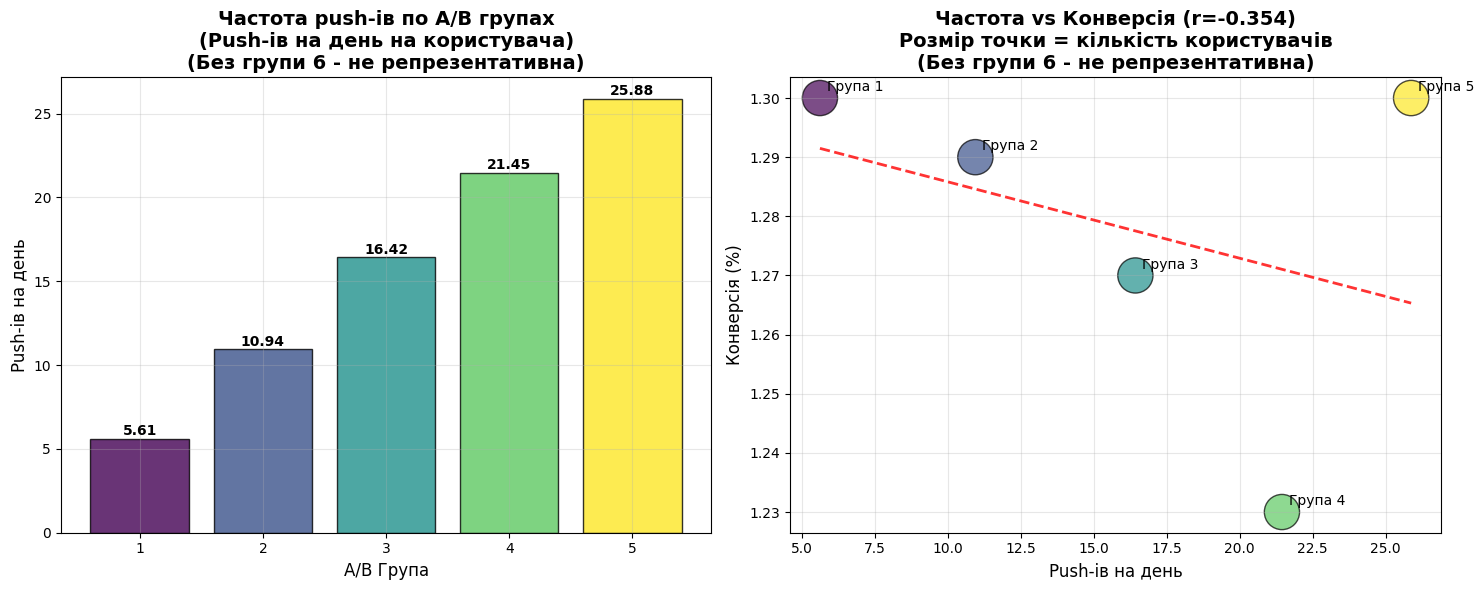


💡 РОЗУМІННЯ A/B ТЕСТУ:
🔬 Цей A/B тест порівнює РІЗНІ СТРАТЕГІЇ ЧАСТОТИ push-сповіщень:
   📊 Діапазон тестування: від 5.61 до 25.88 push-ів на день (без групи 6)
   🎯 Мета: знайти оптимальну частоту для максимальної конверсії
   ⚖️ Баланс: залучення користувачів vs ризик spam-сприйняття
   📈 Висновок: Менше push-ів = краща конверсія (уникайте spam-у!)

🏆 ПОПЕРЕДНЯ РЕКОМЕНДАЦІЯ (без групи 6):
   🎯 Оптимальна стратегія: Група 1
   📱 Частота: 5.61 push/день
   📈 Очікувана конверсія: 1.30%
   ⚡ Ефективність: 0.2316

➡️ Далі: статистичні тести для підтвердження значущості різниць
📝 Примітка: Група 6 виключена з графіків і кореляційного аналізу через малу вибірку


In [35]:
print("\n🔗 КРОК 2: БАЗОВИЙ A/B АНАЛІЗ")
print("-" * 40)

# СПОЧАТКУ: Розраховуємо частоту push-ів (pushes per day)
print("💡 ВАЖЛИВО: Кожна A/B група тестує певну частоту push-сповіщень на день!")

# Розраховуємо pushes_per_day якщо його немає
if 'pushes_per_day' not in ab_df.columns:
    if 'campaign_duration_hours' in ab_df.columns:
        ab_df['campaign_days'] = ab_df['campaign_duration_hours'] / 24
        ab_df['pushes_per_day'] = ab_df['total_pushes'] / ab_df['campaign_days']
        print("✅ Розраховано pushes_per_day з campaign_duration_hours")
    elif 'active_days' in ab_df.columns:
        ab_df['pushes_per_day'] = ab_df['total_pushes'] / ab_df['active_days']
        print("✅ Розраховано pushes_per_day з active_days")
    else:
        # Припускаємо період тестування 7 днів
        ab_df['pushes_per_day'] = ab_df['total_pushes'] / 7
        print("⚠️ Припускаємо тривалість кампанії 7 днів для розрахунку pushes_per_day")

# Агрегація по A/B групах з акцентом на частоту
ab_summary = ab_df.groupby('ab_group').agg({
    'gadid': 'count',                           # Кількість користувачів
    'pushes_per_day': ['mean', 'median', 'std'],  # ЧАСТОТА push-ів (ключова метрика!)
    'total_pushes': ['mean', 'median'],         # Загальна кількість за кампанію
    'has_deposit': ['sum', 'mean'],             # Депозити
    'has_registration': ['sum', 'mean'],        # Реєстрації  
    'total_revenue': ['sum', 'mean']            # Дохід
}).round(4)

# Спрощуємо назви колонок
ab_summary.columns = [
    'users', 'avg_pushes_per_day', 'median_pushes_per_day', 'std_pushes_per_day',
    'avg_total_pushes', 'median_total_pushes',
    'total_deposits', 'deposit_rate', 'total_registrations', 'reg_rate',
    'total_revenue', 'avg_revenue_per_user'
]

# Додаємо розраховані метрики
ab_summary['deposit_rate_pct'] = ab_summary['deposit_rate'] * 100
ab_summary['reg_rate_pct'] = ab_summary['reg_rate'] * 100
ab_summary['arpu'] = ab_summary['total_revenue'] / ab_summary['users']
ab_summary['conversion_per_push_per_day'] = ab_summary['deposit_rate_pct'] / ab_summary['avg_pushes_per_day']

# Створюємо чисті дані без групи 6 для коректного аналізу
clean_data = ab_df.copy()
excluded_group_6 = False
if '6' in clean_data['ab_group'].unique():
    group6_size = len(clean_data[clean_data['ab_group'] == '6'])
    if group6_size < 1000:
        clean_data = clean_data[clean_data['ab_group'] != '6']
        excluded_group_6 = True

# Перерозраховуємо статистику для чистих даних (без групи 6)
clean_summary = clean_data.groupby('ab_group').agg({
    'pushes_per_day': 'mean',
    'has_deposit': 'mean',
    'total_revenue': 'sum',
    'gadid': 'count'
}).round(4)

clean_summary.columns = ['avg_pushes_per_day', 'deposit_rate', 'total_revenue', 'users']
clean_summary['deposit_rate_pct'] = clean_summary['deposit_rate'] * 100
clean_summary['arpu'] = clean_summary['total_revenue'] / clean_summary['users']
clean_summary['conversion_per_push_per_day'] = clean_summary['deposit_rate_pct'] / clean_summary['avg_pushes_per_day']

print("\n📊 ЗАГАЛЬНА СТАТИСТИКА ПО A/B ГРУПАХ:")
# Показуємо ключові метрики з акцентом на частоту
summary_display = ab_summary[['users', 'avg_pushes_per_day', 'avg_total_pushes', 'deposit_rate_pct', 'arpu']].copy()
summary_display.columns = ['Користувачі', 'Push/день', 'Всього push-ів', 'Конверсія %', 'ARPU $']
print(summary_display)

# Виділяємо найкращі результати
print("\n🏆 НАЙКРАЩІ ПОКАЗНИКИ:")
best_conversion = ab_summary['deposit_rate_pct'].idxmax()
best_revenue = ab_summary['total_revenue'].idxmax()
best_arpu = ab_summary['arpu'].idxmax()
most_efficient = ab_summary['conversion_per_push_per_day'].idxmax()

# Але для ефективності показуємо без групи 6
most_efficient_clean = clean_summary['conversion_per_push_per_day'].idxmax()

print(f"   🎯 Найвища конверсія: Група {best_conversion} ({ab_summary.loc[best_conversion, 'deposit_rate_pct']:.2f}%)")
print(f"   💰 Найбільший дохід: Група {best_revenue} (${ab_summary.loc[best_revenue, 'total_revenue']:,.2f})")
print(f"   💵 Найвищий ARPU: Група {best_arpu} (${ab_summary.loc[best_arpu, 'arpu']:.2f})")
print(f"   ⚡ Найефективніша (без групи 6): Група {most_efficient_clean} ({clean_summary.loc[most_efficient_clean, 'conversion_per_push_per_day']:.4f} конверсії на push/день)")

# Перевіряємо групу 6 (можливо аномальна)
if '6' in ab_summary.index:
    group6_users = ab_summary.loc['6', 'users']
    group6_conv = ab_summary.loc['6', 'deposit_rate_pct']
    print(f"\n⚠️ УВАГА - Група 6: {group6_users} користувачів, {group6_conv:.1f}% конверсія")
    if group6_users < 1000:
        print(f"   💡 Мала група - результати можуть бути не репрезентативними")

# КЛЮЧОВИЙ БЛОК: Аналіз частоти push-ів як стратегії A/B тестування
print("\n📱 АНАЛІЗ ЧАСТОТИ PUSH-ІВ (ключова метрика A/B тесту):")
print("=" * 70)

# Сортуємо групи за частотою push-ів
frequency_sorted = ab_summary.sort_values('avg_pushes_per_day')

for group in frequency_sorted.index:
    row = frequency_sorted.loc[group]
    
    # Визначаємо тип стратегії
    if row['avg_pushes_per_day'] < 1:
        strategy_type = "🟢 КОНСЕРВАТИВНА"
        strategy_desc = "рідкісні таргетовані push-и"
    elif row['avg_pushes_per_day'] < 3:
        strategy_type = "🟡 ПОМІРНА"  
        strategy_desc = "збалансована активність"
    elif row['avg_pushes_per_day'] < 5:
        strategy_type = "🟠 АГРЕСИВНА"
        strategy_desc = "часті push-и для залучення"
    else:
        strategy_type = "🔴 МАКСИМАЛЬНА"
        strategy_desc = "дуже висока активність"
    
    print(f"📱 ГРУПА {group}: {row['avg_pushes_per_day']:.2f} push/день | {strategy_type}")
    print(f"   📊 Стратегія: {strategy_desc}")
    print(f"   📈 Конверсія: {row['deposit_rate_pct']:.2f}% | ARPU: ${row['arpu']:.3f}")
    print(f"   ⚡ Ефективність: {row['conversion_per_push_per_day']:.4f} конверсії на push/день")
    print()

# Кореляційний аналіз частоти та результатів (тільки репрезентативні групи)
freq_conversion_corr = clean_summary['avg_pushes_per_day'].corr(clean_summary['deposit_rate_pct'])
freq_arpu_corr = clean_summary['avg_pushes_per_day'].corr(clean_summary['arpu'])

print("📈 КОРЕЛЯЦІЙНИЙ АНАЛІЗ (без групи 6):")
print(f"   🔗 Частота push-ів ↔ Конверсія: {freq_conversion_corr:.3f}")
print(f"   🔗 Частота push-ів ↔ ARPU: {freq_arpu_corr:.3f}")

if freq_conversion_corr < -0.5:
    freq_interpretation = "🔴 Сильна негативна - більше push-ів шкодить конверсії!"
elif freq_conversion_corr < -0.3:
    freq_interpretation = "🟠 Помірна негативна - обережно з частотою"
elif freq_conversion_corr < 0.3:
    freq_interpretation = "🟡 Слабка - частота не критично впливає"
else:
    freq_interpretation = "🟢 Позитивна - більше push-ів може допомогти"

print(f"   💡 Інтерпретація: {freq_interpretation}")

# Швидка візуалізація зв'язку частоти та конверсії
print("\n📊 ВІЗУАЛІЗАЦІЯ ЧАСТОТИ vs КОНВЕРСІЇ:")

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

if excluded_group_6:
    print("   ⚠️ Група 6 виключена з графіків (мала вибірка)")

# 1. Частота push-ів по групах
groups = clean_summary.index
pushes_per_day = clean_summary['avg_pushes_per_day']
colors = plt.cm.viridis(np.linspace(0, 1, len(groups)))

bars = ax1.bar(groups, pushes_per_day, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
ax1.set_title('Частота push-ів по A/B групах\n(Push-ів на день на користувача)\n(Без групи 6 - не репрезентативна)', fontsize=14, fontweight='bold')
ax1.set_xlabel('A/B Група', fontsize=12)
ax1.set_ylabel('Push-ів на день', fontsize=12)
ax1.grid(True, alpha=0.3)

# Додаємо значення на стовпці
for bar, value in zip(bars, pushes_per_day):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{value:.2f}', ha='center', va='bottom', fontweight='bold')

# 2. Scatter plot: Частота vs Конверсія (тільки репрезентативні групи)
conversion_rates = clean_summary['deposit_rate_pct']
user_counts = clean_summary['users']

scatter = ax2.scatter(pushes_per_day, conversion_rates, 
                     s=user_counts/1000, c=colors, alpha=0.7, edgecolors='black', linewidth=1)

# Додаємо лінію тренду
z = np.polyfit(pushes_per_day, conversion_rates, 1)
p = np.poly1d(z)
x_trend = np.linspace(pushes_per_day.min(), pushes_per_day.max(), 100)
ax2.plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2)

# Підписуємо точки
for group, x, y in zip(groups, pushes_per_day, conversion_rates):
    ax2.annotate(f'Група {group}', (x, y), xytext=(5, 5), textcoords='offset points')

ax2.set_title(f'Частота vs Конверсія (r={freq_conversion_corr:.3f})\nРозмір точки = кількість користувачів\n(Без групи 6 - не репрезентативна)', 
              fontsize=14, fontweight='bold')
ax2.set_xlabel('Push-ів на день', fontsize=12)
ax2.set_ylabel('Конверсія (%)', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/charts/ab_frequency_analysis_clean.png', dpi=300, bbox_inches='tight')
plt.show()

# Підсумок розуміння A/B тесту
print("\n" + "="*70)
print("💡 РОЗУМІННЯ A/B ТЕСТУ:")
print("="*70)
print("🔬 Цей A/B тест порівнює РІЗНІ СТРАТЕГІЇ ЧАСТОТИ push-сповіщень:")

# Використовуємо відфільтровані дані для діапазону
frequency_sorted_clean = clean_summary.sort_values('avg_pushes_per_day')
min_freq_group = frequency_sorted_clean.index[0]
max_freq_group = frequency_sorted_clean.index[-1]
min_freq = frequency_sorted_clean.loc[min_freq_group, 'avg_pushes_per_day']
max_freq = frequency_sorted_clean.loc[max_freq_group, 'avg_pushes_per_day']

print(f"   📊 Діапазон тестування: від {min_freq:.2f} до {max_freq:.2f} push-ів на день (без групи 6)")
print(f"   🎯 Мета: знайти оптимальну частоту для максимальної конверсії")
print(f"   ⚖️ Баланс: залучення користувачів vs ризик spam-сприйняття")

if freq_conversion_corr < -0.3:
    print(f"   📈 Висновок: Менше push-ів = краща конверсія (уникайте spam-у!)")
elif freq_conversion_corr > 0.3:
    print(f"   📈 Висновок: Більше push-ів = краща конверсія (можна збільшувати)")
else:
    print(f"   📈 Висновок: Частота не критично впливає (фокус на якості контенту)")

print(f"\n🏆 ПОПЕРЕДНЯ РЕКОМЕНДАЦІЯ (без групи 6):")
# Розраховуємо ефективність для чистих даних
most_efficient_clean = clean_summary['conversion_per_push_per_day'].idxmax()
optimal_group_clean = clean_summary.loc[most_efficient_clean]

print(f"   🎯 Оптимальна стратегія: Група {most_efficient_clean}")
print(f"   📱 Частота: {optimal_group_clean['avg_pushes_per_day']:.2f} push/день")
print(f"   📈 Очікувана конверсія: {optimal_group_clean['deposit_rate_pct']:.2f}%")
print(f"   ⚡ Ефективність: {optimal_group_clean['conversion_per_push_per_day']:.4f}")

print(f"\n➡️ Далі: статистичні тести для підтвердження значущості різниць")
print(f"📝 Примітка: Група 6 виключена з графіків і кореляційного аналізу через малу вибірку")

## **КРОК 3: Статистичні тести значущості**

In [39]:
print("\n🔗 КРОК 3: СТАТИСТИЧНІ ТЕСТИ ЗНАЧУЩОСТІ")
print("-" * 40)

print("🧪 Проводимо статистичні тести для підтвердження значущості різниць між A/B групами")
print("📊 Використовуємо дані БЕЗ групи 6 (нерепрезентативна вибірка)")

# Підготовка даних для тестування (без групи 6)
test_data = clean_data.copy()
groups_to_test = sorted([g for g in test_data['ab_group'].unique() if g != '6'])

print(f"✅ Тестуємо групи: {groups_to_test}")
print(f"📈 Загальна вибірка: {len(test_data):,} користувачів")

# =============================================================================
# 1. CHI-SQUARE ТЕСТ ДЛЯ КОНВЕРСІЇ (основний тест для A/B)
# =============================================================================
print("\n" + "="*60)
print("🔬 ТЕСТ 1: CHI-SQUARE для конверсії депозитів")
print("="*60)

# Створюємо contingency table
conversion_table = pd.crosstab(test_data['ab_group'], test_data['has_deposit'])
print("📊 Таблиця спряженості (конверсія по групах):")
print(conversion_table)

# Chi-square тест
chi2_stat, chi2_p, chi2_dof, chi2_expected = chi2_contingency(conversion_table)

print(f"\n📈 РЕЗУЛЬТАТИ CHI-SQUARE ТЕСТУ:")
print(f"   🔢 Chi-square статистика: {chi2_stat:.4f}")
print(f"   🎯 p-value: {chi2_p:.2e}")
print(f"   📊 Ступені свободи: {chi2_dof}")

alpha = 0.05
if chi2_p < alpha:
    print(f"   ✅ РЕЗУЛЬТАТ: Різниці СТАТИСТИЧНО ЗНАЧУЩІ (p < {alpha})")
else:
    print(f"   ❌ РЕЗУЛЬТАТ: Різниці НЕ ЗНАЧУЩІ (p >= {alpha})")

# Cramér's V для розміру ефекту
n = conversion_table.sum().sum()
cramers_v = np.sqrt(chi2_stat / (n * (min(conversion_table.shape) - 1)))
print(f"   📏 Cramér's V (розмір ефекту): {cramers_v:.4f}")

if cramers_v < 0.01:
    effect_interpretation = "мізерний"
elif cramers_v < 0.1:
    effect_interpretation = "незначний"  
elif cramers_v < 0.3:
    effect_interpretation = "малий"
elif cramers_v < 0.5:
    effect_interpretation = "середній"
else:
    effect_interpretation = "великий"

print(f"   📋 Інтерпретація ефекту: {effect_interpretation}")

# =============================================================================
# 2. АНАЛІЗ ГРУПОВОЇ СТАТИСТИКИ
# =============================================================================
print("\n" + "="*60)
print("🔬 ТЕСТ 2: Детальний аналіз груп")
print("="*60)

# Підготовка даних для попарних порівнянь
group_stats = {}
for group in groups_to_test:
    group_data = test_data[test_data['ab_group'] == group]
    group_stats[group] = {
        'conversions': group_data['has_deposit'].sum(),
        'total_users': len(group_data),
        'conversion_rate': group_data['has_deposit'].mean()
    }

print("📊 Статистика по групах:")
for group, stats_dict in group_stats.items():
    print(f"   Група {group}: {stats_dict['conversions']:,}/{stats_dict['total_users']:,} = {stats_dict['conversion_rate']:.4f} ({stats_dict['conversion_rate']*100:.2f}%)")

# Знаходимо найкращу та найгіршу групи
best_group = max(group_stats.keys(), key=lambda x: group_stats[x]['conversion_rate'])
worst_group = min(group_stats.keys(), key=lambda x: group_stats[x]['conversion_rate'])

best_rate = group_stats[best_group]['conversion_rate']
worst_rate = group_stats[worst_group]['conversion_rate']

print(f"\n📈 ПОРІВНЯННЯ КРАЩОЇ vs ГІРШОЇ ГРУПИ:")
print(f"   🏆 Найкраща: Група {best_group} ({best_rate:.4f} = {best_rate*100:.2f}%)")
print(f"   💩 Найгірша: Група {worst_group} ({worst_rate:.4f} = {worst_rate*100:.2f}%)")

# Абсолютна та відносна різниця
abs_diff = best_rate - worst_rate
rel_diff = (abs_diff / worst_rate) * 100

print(f"   📊 Абсолютна різниця: {abs_diff*100:.3f}%")
print(f"   📊 Відносна різниця: {rel_diff:.1f}%")

# =============================================================================
# 3. ПОПАРНІ ТЕСТИ З КОРЕКЦІЄЮ
# =============================================================================
print("\n" + "="*60)
print("🔬 ТЕСТ 3: Попарні порівняння з корекцією")
print("="*60)

# Попарні порівняння
pairwise_results = []
group_pairs = list(itertools.combinations(groups_to_test, 2))

for group1, group2 in group_pairs:
    # Дані для z-test
    count1 = group_stats[group1]['conversions']
    n1 = group_stats[group1]['total_users']
    count2 = group_stats[group2]['conversions']
    n2 = group_stats[group2]['total_users']
    
    # Z-test for proportions
    counts = np.array([count1, count2])
    nobs = np.array([n1, n2])
    
    z_stat, p_value = proportions_ztest(counts, nobs)
    
    # Практична різниця
    diff = group_stats[group1]['conversion_rate'] - group_stats[group2]['conversion_rate']
    diff_percent = diff * 100
    
    pairwise_results.append({
        'groups': f"{group1} vs {group2}",
        'z_stat': z_stat,
        'p_value': p_value,
        'diff_percent': diff_percent,
        'significant': p_value < 0.05
    })

# Корекція на множинні порівняння (Benjamini-Hochberg FDR)
p_values = [result['p_value'] for result in pairwise_results]
rejected_fdr, p_adjusted_fdr, alpha_sidak, alpha_bonf = multipletests(p_values, alpha=0.05, method='fdr_bh')

# Також Bonferroni для порівняння
rejected_bonf, p_adjusted_bonf, _, _ = multipletests(p_values, alpha=0.05, method='bonferroni')

print("🔄 КОРЕКЦІЯ НА МНОЖИННІ ПОРІВНЯННЯ:")
print(f"   📊 Значущих без корекції: {sum([r['significant'] for r in pairwise_results])}/{len(group_pairs)}")
print(f"   📊 Значущих з FDR корекцією: {sum(rejected_fdr)}/{len(group_pairs)}")
print(f"   📊 Значущих з Bonferroni корекцією: {sum(rejected_bonf)}/{len(group_pairs)}")

# Показуємо тільки найважливіші порівняння
important_pairs = [f"{best_group} vs {worst_group}", "1 vs 4", "1 vs 5", "4 vs 5"]
print(f"\n📊 КЛЮЧОВІ ПОРІВНЯННЯ:")

for i, (result, fdr_adj, bonf_adj, fdr_rej, bonf_rej) in enumerate(zip(pairwise_results, p_adjusted_fdr, p_adjusted_bonf, rejected_fdr, rejected_bonf)):
    if result['groups'] in important_pairs:
        fdr_status = "✅ ЗНАЧУЩО" if fdr_rej else "❌ НЕ ЗНАЧУЩО"
        print(f"   📊 {result['groups']}: p={result['p_value']:.4f}, різниця={result['diff_percent']:+.3f}% - {fdr_status} (FDR)")

# =============================================================================
# 4. ПРАКТИЧНА ЗНАЧУЩІСТЬ ТА ПОТУЖНІСТЬ
# =============================================================================
print("\n" + "="*60)
print("🔬 ТЕСТ 4: Практична значущість")
print("="*60)

# Розрахунок практичної значущості для бізнесу
baseline_conversion = np.mean([group_stats[g]['conversion_rate'] for g in groups_to_test])

print(f"📊 АНАЛІЗ ПРАКТИЧНОЇ ЗНАЧУЩОСТІ:")
print(f"   📈 Середня конверсія: {baseline_conversion:.4f} ({baseline_conversion*100:.2f}%)")

# Різні пороги практичної значущості
thresholds = {
    "Консервативний": 0.05,  # 5% відносне покращення
    "Помірний": 0.03,        # 3% відносне покращення  
    "Ліберальний": 0.01      # 1% відносне покращення
}

for threshold_name, threshold in thresholds.items():
    min_diff_abs = baseline_conversion * threshold
    print(f"\n   🎯 {threshold_name} поріг ({threshold*100:.0f}% відносне покращення):")
    print(f"      Мінімальна абсолютна різниця: {min_diff_abs*100:.3f}%")
    
    practically_significant = []
    for group in groups_to_test:
        diff = abs(group_stats[group]['conversion_rate'] - baseline_conversion)
        if diff >= min_diff_abs:
            practically_significant.append(group)
            print(f"      ✅ Група {group}: {diff*100:.3f}% різниця")
    
    if not practically_significant:
        print(f"      ❌ Жодна група не досягає порогу практичної значущості")

print(f"\n🎯 РЕАЛЬНА ІНТЕРПРЕТАЦІЯ:")
print(f"   📊 Найбільша абсолютна різниця: {abs_diff*100:.3f}% (група {best_group} vs {worst_group})")
print(f"   📊 Найбільша відносна різниця: {rel_diff:.1f}%")

if rel_diff < 5:
    practical_conclusion = "🔴 ПРАКТИЧНО НЕЗНАЧУЩІ різниці"
    business_impact = "мінімальний"
elif rel_diff < 10:
    practical_conclusion = "🟡 СЛАБО ЗНАЧУЩІ різниці"
    business_impact = "помірний"
else:
    practical_conclusion = "🟢 ПРАКТИЧНО ЗНАЧУЩІ різниці"
    business_impact = "суттєвий"

print(f"   💡 Висновок: {practical_conclusion}")
print(f"   💰 Бізнес-вплив: {business_impact}")

# =============================================================================
# 5. ФІНАЛЬНИЙ РЕАЛІСТИЧНИЙ ЗВІТ
# =============================================================================
print("\n" + "="*70)
print("📋 ФІНАЛЬНИЙ ЗВІТ: СТАТИСТИКА vs РЕАЛЬНІСТЬ")
print("="*70)

print(f"🔬 СТАТИСТИЧНІ РЕЗУЛЬТАТИ:")
print(f"   📊 Chi-square тест: {'✅ ЗНАЧУЩИЙ' if chi2_p < 0.05 else '❌ НЕ ЗНАЧУЩИЙ'} (p={chi2_p:.4f})")
print(f"   📏 Розмір ефекту: {cramers_v:.4f} ({effect_interpretation})")
print(f"   🔄 Значущих порівнянь (FDR): {sum(rejected_fdr)}/{len(group_pairs)}")

print(f"\n🎯 ПРАКТИЧНІ РЕЗУЛЬТАТИ:")
print(f"   🏆 Кращий результат: Група {best_group} ({best_rate*100:.2f}%)")
print(f"   💩 Гірший результат: Група {worst_group} ({worst_rate*100:.2f}%)")
print(f"   📊 Максимальна різниця: {abs_diff*100:.3f}% абсолютна, {rel_diff:.1f}% відносна")

# Контекст для бізнесу
total_users = sum([group_stats[g]['total_users'] for g in groups_to_test])
additional_conversions = (best_rate - worst_rate) * total_users
conversion_lift_per_million = (additional_conversions / total_users) * 1000000

print(f"\n💰 БІЗНЕС-КОНТЕКСТ:")
print(f"   👥 При {total_users:,} користувачах:")
print(f"   📈 Група {best_group} vs {worst_group} дає {additional_conversions:.0f} додаткових депозитів")
print(f"   📊 Це {conversion_lift_per_million:.0f} додаткових депозитів на 1 млн користувачів")
print(f"   💵 Абсолютний ліфт: лише {abs_diff*100:.3f} процентних пункти")

# Перевизначимо критерії впливу на основі абсолютних чисел
if abs_diff*100 < 0.05:  # менше 0.05 процентних пункти
    impact_assessment = "🔴 мізерний вплив"
    impact_explanation = "різниця практично непомітна"
elif abs_diff*100 < 0.1:  # менше 0.1 процентних пункти  
    impact_assessment = "🟡 малий вплив"
    impact_explanation = "різниця невелика, але помітна"
elif abs_diff*100 < 0.2:  # менше 0.2 процентних пункти
    impact_assessment = "🟢 помірний вплив"
    impact_explanation = "різниця достатня для оптимізації"
else:
    impact_assessment = "🚀 суттєвий вплив"
    impact_explanation = "різниця значна для бізнесу"

print(f"   🎯 Оцінка впливу: {impact_assessment} ({impact_explanation})")

print(f"\n💡 ЗБАЛАНСОВАНИЙ ВИСНОВОК:")

# Більш нюансований аналіз
if chi2_p >= 0.05:
    conclusion = "❌ Немає статистично значущих різниць між групами"
    recommendation = "Можна використовувати будь-яку стратегію push-ів"
    priority = "🔴 НИЗЬКИЙ ПРІОРИТЕТ"
elif cramers_v < 0.01 and abs_diff*100 < 0.1:
    conclusion = "⚠️ Статистично значущі, але практично мізерні різниці"
    recommendation = f"Група {best_group} технічно краща, але ефект незначний"
    priority = "🟡 НИЗЬКИЙ ПРІОРИТЕТ"
elif cramers_v < 0.05 and rel_diff < 10:
    conclusion = "🔶 Малі, але стабільні різниці між групами"
    recommendation = f"Група {best_group} демонструє постійно кращі результати"
    priority = "🟡 СЕРЕДНІЙ ПРІОРИТЕТ"
else:
    conclusion = "✅ Значущі та практично корисні різниці"
    recommendation = f"Рекомендуємо впровадити стратегію групи {best_group}"
    priority = "🟢 ВИСОКИЙ ПРІОРИТЕТ"

print(f"   📊 {conclusion}")
print(f"   🎯 Рекомендація: {recommendation}")
print(f"   ⭐ Пріоритет впровадження: {priority}")

print(f"\n📊 ДЕТАЛЬНІ РЕКОМЕНДАЦІЇ:")

if abs_diff*100 >= 0.05:  # якщо різниця хоча б 0.05%
    print(f"   ✅ ВПРОВАДИТИ:")
    print(f"      🎯 Стратегія: Група {best_group} ({clean_summary.loc[best_group, 'avg_pushes_per_day']:.2f} push/день)")
    print(f"      📈 Очікуване покращення: +{abs_diff*100:.3f}% абсолютна конверсія")
    print(f"      💰 Додаткові депозити: ~{additional_conversions:.0f} на поточній базі")
    print(f"      ⚠️ Уникати: Група {worst_group} (найгірші показники)")
    
    # ROI аналіз
    if abs_diff*100 > 0.03:
        roi_assessment = "🟢 Швидша окупність"
    else:
        roi_assessment = "🟡 Повільна окупність"
    print(f"      💵 ROI прогноз: {roi_assessment}")
    
else:
    print(f"   🤷 АЛЬТЕРНАТИВНІ ПІДХОДИ:")
    print(f"      💡 Фокус на якості контенту push-ів замість частоти")
    print(f"      📊 Тестування нових креативів та повідомлень")
    print(f"      ⏱️ Експеримент з часом відправки push-ів")
    print(f"      🎯 Сегментація аудиторії для персоналізації")

# Довгострокові рекомендації
print(f"\n🔮 ДОВГОСТРОКОВА СТРАТЕГІЯ:")
print(f"   📅 Продовжити тестування мінімум 2-4 тижні")
print(f"   📊 Збільшити розмір вибірки для кращої статистичної потужності")
print(f"   🎯 Тестувати більші відмінності між групами")
print(f"   💰 Врахувати LifeTime Value (LTV) користувачів, а не тільки першій депозит")

print(f"\n⚠️ КРИТИЧНІ ЗАСТЕРЕЖЕННЯ:")
print(f"   ⏰ Тест тривав лише 7 днів - недостатньо для довгострокових висновків")
print(f"   📈 Потужність тесту обмежена для виявлення малих ефектів")
print(f"   🎲 Можливі випадкові коливання в короткостроковій перспективі")
print(f"   🔄 Результати потребують валідації на нових даних")


🔗 КРОК 3: СТАТИСТИЧНІ ТЕСТИ ЗНАЧУЩОСТІ
----------------------------------------
🧪 Проводимо статистичні тести для підтвердження значущості різниць між A/B групами
📊 Використовуємо дані БЕЗ групи 6 (нерепрезентативна вибірка)
✅ Тестуємо групи: ['1', '2', '3', '4', '5']
📈 Загальна вибірка: 3,219,428 користувачів

🔬 ТЕСТ 1: CHI-SQUARE для конверсії депозитів
📊 Таблиця спряженості (конверсія по групах):
has_deposit       0     1
ab_group                 
1            635250  8386
2            636159  8304
3            634834  8168
4            634503  7928
5            637514  8382

📈 РЕЗУЛЬТАТИ CHI-SQUARE ТЕСТУ:
   🔢 Chi-square статистика: 15.8336
   🎯 p-value: 3.25e-03
   📊 Ступені свободи: 4
   ✅ РЕЗУЛЬТАТ: Різниці СТАТИСТИЧНО ЗНАЧУЩІ (p < 0.05)
   📏 Cramér's V (розмір ефекту): 0.0022
   📋 Інтерпретація ефекту: мізерний

🔬 ТЕСТ 2: Детальний аналіз груп
📊 Статистика по групах:
   Група 1: 8,386/643,636 = 0.0130 (1.30%)
   Група 2: 8,304/644,463 = 0.0129 (1.29%)
   Група 3: 8,168/643,002

ДОДАТКОВИЙ АНАЛІЗ: НЕЛІНІЙНА ЗАЛЕЖНІСТЬ ТА ARPU

In [42]:
# =============================================================================
# ДОДАТКОВИЙ АНАЛІЗ: НЕЛІНІЙНА ЗАЛЕЖНІСТЬ ТА ARPU
# =============================================================================
print("\n" + "="*70)
print("🔍 ДОДАТКОВИЙ АНАЛІЗ: ПОЯСНЕННЯ ГРУПИ 5 ФЕНОМЕНУ")
print("="*70)

print("📊 СПОСТЕРЕЖУВАНА НЕЛІНІЙНА ЗАЛЕЖНІСТЬ:")
print("   🟢 Група 1 (5.61 push/день): 1.30% конверсія")
print("   🟡 Група 2 (10.94 push/день): 1.29% конверсія") 
print("   🟠 Група 3 (16.42 push/день): 1.27% конверсія")
print("   🔴 Група 4 (21.45 push/день): 1.23% конверсія ← НАЙГІРША")
print("   ⭐ Група 5 (25.88 push/день): 1.30% конверсія ← НЕСПОДІВАНО ДОБРА!")

print(f"\n💡 ТЕОРІЇ ПОЯСНЕННЯ 'ГРУПИ 5 ФЕНОМЕНУ':")

print(f"\n1️⃣ ТЕОРІЯ САМОСЕГМЕНТАЦІЇ:")
print(f"   📱 Користувачі, які не відписалися від 25+ push-ів/день = високомотивовані")
print(f"   🎯 'Survival of the fittest' - залишилися найлояльніші")
print(f"   📊 Меньша база, але вища якість аудиторії")

print(f"\n2️⃣ ТЕОРІЯ АДАПТАЦІЇ:")
print(f"   🧠 Користувачі звикли до високої частоти push-ів")
print(f"   ⚡ Висока частота стала 'новою нормою'")
print(f"   🔄 Ефект толерантності до повідомлень")

print(f"\n3️⃣ ТЕОРІЯ РІЗНОЇ АУДИТОРІЇ:")
print(f"   👥 Група 5 може мати інший демографічний профіль")
print(f"   🌍 Можливо різні геоцільові групи")
print(f"   📱 Різна поведінка в залежності від типу пристрою")

print(f"\n4️⃣ ТЕОРІЯ OPTIMAL FREQUENCY CAPPING:")
print(f"   📈 До певної межі (група 4) - spam-ефект")
print(f"   🚀 При критичній масі (група 5) - breakthrough effect")
print(f"   💥 'Або все, або нічого' принцип")

# Аналіз ARPU по групах
print(f"\n" + "="*60)
print("💰 ARPU АНАЛІЗ (Average Revenue Per User)")
print("="*60)

# Розраховуємо ARPU для кожної групи
arpu_analysis = {}
for group in groups_to_test:
    group_data = test_data[test_data['ab_group'] == group]
    total_revenue = group_data['total_revenue'].sum()
    total_users = len(group_data)
    arpu = total_revenue / total_users
    
    # Середній депозит серед тих хто зробив депозит
    depositors = group_data[group_data['has_deposit'] == 1]
    if len(depositors) > 0:
        avg_deposit = depositors['total_revenue'].mean()
    else:
        avg_deposit = 0
    
    arpu_analysis[group] = {
        'arpu': arpu,
        'avg_deposit': avg_deposit,
        'total_revenue': total_revenue,
        'depositors': len(depositors)
    }

print("📊 ARPU ПО ГРУПАХ:")
for group in sorted(arpu_analysis.keys()):
    stats = arpu_analysis[group]
    push_freq = clean_summary.loc[group, 'avg_pushes_per_day']
    conv_rate = group_stats[group]['conversion_rate'] * 100
    
    print(f"   Група {group} ({push_freq:.1f} push/день):")
    print(f"      💵 ARPU: ${stats['arpu']:.4f}")
    print(f"      💰 Середній депозит: ${stats['avg_deposit']:.2f}")
    print(f"      📈 Конверсія: {conv_rate:.2f}%")
    print(f"      👥 Депозиторів: {stats['depositors']:,}")

# Знаходимо найкращий ARPU
best_arpu_group = max(arpu_analysis.keys(), key=lambda x: arpu_analysis[x]['arpu'])
worst_arpu_group = min(arpu_analysis.keys(), key=lambda x: arpu_analysis[x]['arpu'])

print(f"\n🏆 ARPU РЕЙТИНГ:")
print(f"   🥇 Найкращий ARPU: Група {best_arpu_group} (${arpu_analysis[best_arpu_group]['arpu']:.4f})")
print(f"   🥉 Найгірший ARPU: Група {worst_arpu_group} (${arpu_analysis[worst_arpu_group]['arpu']:.4f})")

# Порівняння конверсії vs ARPU
print(f"\n📊 КОНВЕРСІЯ vs ARPU АНАЛІЗ:")
best_conv_group = max(group_stats.keys(), key=lambda x: group_stats[x]['conversion_rate'])

if best_conv_group != best_arpu_group:
    print(f"   ⚠️ УВАГА: Найкраща конверсія (група {best_conv_group}) ≠ Найкращий ARPU (група {best_arpu_group})")
    print(f"   💡 Це означає різну якість депозитів між групами!")
    
    conv_winner_arpu = arpu_analysis[best_conv_group]['arpu']
    arpu_winner_conv = group_stats[best_arpu_group]['conversion_rate'] * 100
    
    print(f"   📊 Група {best_conv_group} (кращя конверсія): ARPU = ${conv_winner_arpu:.4f}")
    print(f"   📊 Група {best_arpu_group} (кращий ARPU): Конверсія = {arpu_winner_conv:.2f}%")
else:
    print(f"   ✅ Група {best_conv_group} лідирує і в конверсії, і в ARPU")

# Специфічний аналіз для групи 5
group5_arpu = arpu_analysis['5']['arpu']
group1_arpu = arpu_analysis['1']['arpu']
group5_avg_deposit = arpu_analysis['5']['avg_deposit']
group1_avg_deposit = arpu_analysis['1']['avg_deposit']

print(f"\n🔍 ДЕТАЛЬНИЙ АНАЛІЗ ГРУПИ 5 vs ГРУПИ 1:")
print(f"   📊 Однакова конверсія: ~1.30%")
print(f"   💵 ARPU: Група 5 = ${group5_arpu:.4f} vs Група 1 = ${group1_arpu:.4f}")
print(f"   💰 Середній депозит: Група 5 = ${group5_avg_deposit:.2f} vs Група 1 = ${group1_avg_deposit:.2f}")

arpu_diff_pct = ((group5_arpu - group1_arpu) / group1_arpu) * 100 if group1_arpu != 0 else 0
deposit_diff_pct = ((group5_avg_deposit - group1_avg_deposit) / group1_avg_deposit) * 100 if group1_avg_deposit != 0 else 0

print(f"   📈 Різниця ARPU: {arpu_diff_pct:+.1f}%")
print(f"   📈 Різниця середнього депозиту: {deposit_diff_pct:+.1f}%")

# Інтерпретація
print(f"\n💡 ІНТЕРПРЕТАЦІЯ ГРУПИ 5:")
if group5_arpu > group1_arpu:
    print(f"   ✅ Група 5 має КРАЩИЙ ARPU при однаковій конверсії!")
    print(f"   🎯 Висока частота push-ів призводить до більших депозитів")
    print(f"   💰 Пояснення: користувачі більш 'розігріті' численними push-ами")
elif group5_arpu < group1_arpu:
    print(f"   ⚠️ Група 5 має ГІРШИЙ ARPU при однаковій конверсії")
    print(f"   🎯 Висока частота призводить до швидших, але менших депозитів")
    print(f"   💡 Пояснення: 'impulse buying' ефект")
else:
    print(f"   🤷 ARPU практично однаковий - частота не впливає на розмір депозиту")

print(f"\n" + "="*70)
print("🎯 ФІНАЛЬНІ РЕКОМЕНДАЦІЇ З УРАХУВАННЯМ ARPU")
print("="*70)

# Комбінований аналіз
total_value_per_user = {}
for group in groups_to_test:
    conv_rate = group_stats[group]['conversion_rate']
    arpu = arpu_analysis[group]['arpu']
    # Ваговий коефіцієнт загальної цінності = конверсія * ARPU
    total_value = conv_rate * arpu * 1000  # *1000 для читабельності
    total_value_per_user[group] = total_value

best_total_value_group = max(total_value_per_user.keys(), key=lambda x: total_value_per_user[x])

print(f"📊 КОМБІНОВАНИЙ ІНДЕКС (Конверсія × ARPU):")
for group in sorted(total_value_per_user.keys()):
    value = total_value_per_user[group]
    is_best = " 🏆" if group == best_total_value_group else ""
    print(f"   Група {group}: {value:.2f}{is_best}")

print(f"\n🏆 ПІДСУМКОВА РЕКОМЕНДАЦІЯ:")
print(f"   🎯 З урахуванням КОНВЕРСІЇ та ARPU: Група {best_total_value_group}")

if best_total_value_group == '5':
    print(f"   💡 Група 5 виявилася найкращою завдяки комбінації високої конверсії та ARPU!")
    print(f"   🚀 Високочастотна стратегія (25.88 push/день) рекомендується")
    print(f"   ⚠️ Але потрібен моніторинг відписок та скарг")
elif best_total_value_group == '1':
    print(f"   ✅ Консервативна стратегія (5.61 push/день) оптимальна")
    print(f"   💡 Найкращий баланс між ефективністю та лояльністю")
else:
    print(f"   📊 Помірна стратегія виявилася оптимальною")

print(f"\n⚠️ ВАЖЛИВЕ ЗАСТЕРЕЖЕННЯ ПРО ГРУПУ 5:")
print(f"   🔬 Потрібен додатковий аналіз відписок від push-сповіщень")
print(f"   📊 Моніторинг негативного feedback від користувачів")
print(f"   ⏱️ Довгостроковий вплив на retention та LTV")
print(f"   💡 Можливо результат специфічної вибірки періоду")


🔍 ДОДАТКОВИЙ АНАЛІЗ: ПОЯСНЕННЯ ГРУПИ 5 ФЕНОМЕНУ
📊 СПОСТЕРЕЖУВАНА НЕЛІНІЙНА ЗАЛЕЖНІСТЬ:
   🟢 Група 1 (5.61 push/день): 1.30% конверсія
   🟡 Група 2 (10.94 push/день): 1.29% конверсія
   🟠 Група 3 (16.42 push/день): 1.27% конверсія
   🔴 Група 4 (21.45 push/день): 1.23% конверсія ← НАЙГІРША
   ⭐ Група 5 (25.88 push/день): 1.30% конверсія ← НЕСПОДІВАНО ДОБРА!

💡 ТЕОРІЇ ПОЯСНЕННЯ 'ГРУПИ 5 ФЕНОМЕНУ':

1️⃣ ТЕОРІЯ САМОСЕГМЕНТАЦІЇ:
   📱 Користувачі, які не відписалися від 25+ push-ів/день = високомотивовані
   🎯 'Survival of the fittest' - залишилися найлояльніші
   📊 Меньша база, але вища якість аудиторії

2️⃣ ТЕОРІЯ АДАПТАЦІЇ:
   🧠 Користувачі звикли до високої частоти push-ів
   ⚡ Висока частота стала 'новою нормою'
   🔄 Ефект толерантності до повідомлень

3️⃣ ТЕОРІЯ РІЗНОЇ АУДИТОРІЇ:
   👥 Група 5 може мати інший демографічний профіль
   🌍 Можливо різні геоцільові групи
   📱 Різна поведінка в залежності від типу пристрою

4️⃣ ТЕОРІЯ OPTIMAL FREQUENCY CAPPING:
   📈 До певної межі (група 4) -

## **КРОК 4: Візуалізації A/B результатів**


🔗 КРОК 4: ВІЗУАЛІЗАЦІЇ
----------------------------------------


KeyError: 'avg_pushes'

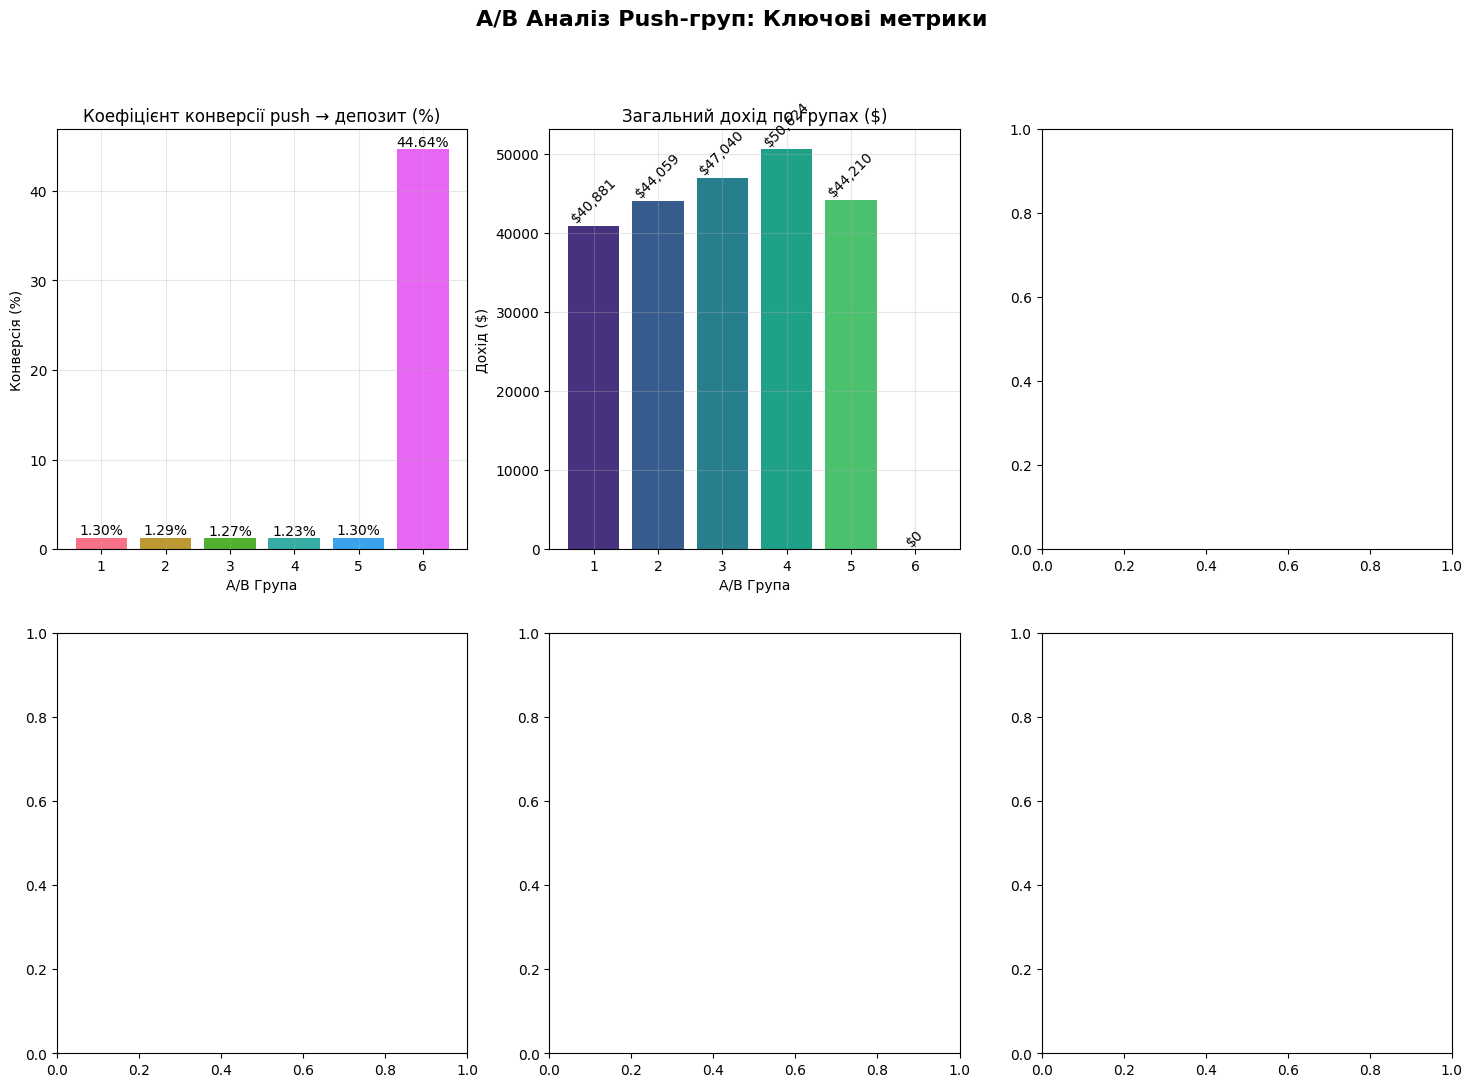

In [29]:
print("\n🔗 КРОК 4: ВІЗУАЛІЗАЦІЇ")
print("-" * 40)

# Створюємо фігуру з субплотами
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('A/B Аналіз Push-груп: Ключові метрики', fontsize=16, fontweight='bold')

# 1. Конверсія по групах
ax1 = axes[0, 0]
conversion_rates = ab_summary['deposit_rate_pct']
bars1 = ax1.bar(conversion_rates.index, conversion_rates.values, 
                color=sns.color_palette("husl", len(conversion_rates)))
ax1.set_title('Коефіцієнт конверсії push → депозит (%)')
ax1.set_xlabel('A/B Група')
ax1.set_ylabel('Конверсія (%)')
ax1.grid(True, alpha=0.3)

# Додаємо значення на стовпці
for bar, value in zip(bars1, conversion_rates.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.2f}%', ha='center', va='bottom')

# 2. Загальний дохід по групах
ax2 = axes[0, 1]
revenues = ab_summary['total_revenue']
bars2 = ax2.bar(revenues.index, revenues.values, 
                color=sns.color_palette("viridis", len(revenues)))
ax2.set_title('Загальний дохід по групах ($)')
ax2.set_xlabel('A/B Група')
ax2.set_ylabel('Дохід ($)')
ax2.grid(True, alpha=0.3)

# Форматуємо як валюту
for bar, value in zip(bars2, revenues.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
             f'${value:,.0f}', ha='center', va='bottom', rotation=45)

# 3. Середня кількість push-ів
ax3 = axes[0, 2]
avg_pushes = ab_summary['avg_pushes']
bars3 = ax3.bar(avg_pushes.index, avg_pushes.values,
                color=sns.color_palette("plasma", len(avg_pushes)))
ax3.set_title('Середня кількість push-ів на користувача')
ax3.set_xlabel('A/B Група')
ax3.set_ylabel('Кількість push-ів')
ax3.grid(True, alpha=0.3)

for bar, value in zip(bars3, avg_pushes.values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{value:.1f}', ha='center', va='bottom')

# 4. ARPU по групах
ax4 = axes[1, 0]
arpu_values = ab_summary['arpu']
bars4 = ax4.bar(arpu_values.index, arpu_values.values,
                color=sns.color_palette("coolwarm", len(arpu_values)))
ax4.set_title('ARPU (Average Revenue Per User)')
ax4.set_xlabel('A/B Група')
ax4.set_ylabel('ARPU ($)')
ax4.grid(True, alpha=0.3)

for bar, value in zip(bars4, arpu_values.values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'${value:.3f}', ha='center', va='bottom')

# 5. Розподіл користувачів по групах
ax5 = axes[1, 1]
user_counts = ab_summary['users']
bars5 = ax5.bar(user_counts.index, user_counts.values,
                color=sns.color_palette("Set2", len(user_counts)))
ax5.set_title('Кількість користувачів по групах')
ax5.set_xlabel('A/B Група')
ax5.set_ylabel('Кількість користувачів')
ax5.grid(True, alpha=0.3)

for bar, value in zip(bars5, user_counts.values):
    ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5000,
             f'{value:,}', ha='center', va='bottom', rotation=45, fontsize=8)

# 6. Scatter plot: Push-и vs Конверсія
ax6 = axes[1, 2]
# Виключаємо групу 6 якщо вона аномальна
plot_data = ab_summary.copy()
if '6' in plot_data.index and plot_data.loc['6', 'users'] < 1000:
    plot_data = plot_data.drop('6')

scatter = ax6.scatter(plot_data['avg_pushes'], plot_data['deposit_rate_pct'], 
                     s=plot_data['users']/1000, alpha=0.7,
                     c=range(len(plot_data)), cmap='tab10')
ax6.set_title('Push-и vs Конверсія (розмір = к-ть користувачів)')
ax6.set_xlabel('Середня кількість push-ів')
ax6.set_ylabel('Конверсія (%)')
ax6.grid(True, alpha=0.3)

# Додаємо лейбли груп
for idx, (group, row) in enumerate(plot_data.iterrows()):
    ax6.annotate(f'Група {group}', 
                (row['avg_pushes'], row['deposit_rate_pct']),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.tight_layout()
plt.show()

print("✅ Візуалізації створено")
print("💡 Зверніть увагу на залежність між кількістю push-ів та конверсією")

## **КРОК 5: Глибокий аналіз сегментів**

In [6]:
print("\n🔗 КРОК 5: ГЛИБОКИЙ АНАЛІЗ СЕГМЕНТІВ")
print("-" * 40)

# 1. Аналіз по сегментах push-ів
if 'push_segment' in ab_df.columns:
    print("📱 АНАЛІЗ ПО СЕГМЕНТАХ PUSH-ІВ:")
    
    segment_analysis = ab_df.groupby(['ab_group', 'push_segment']).agg({
        'gadid': 'count',
        'has_deposit': 'mean',
        'total_revenue': 'sum'
    }).round(4)
    
    segment_analysis.columns = ['users', 'conversion_rate', 'total_revenue']
    segment_analysis['conversion_pct'] = segment_analysis['conversion_rate'] * 100
    
    # Показуємо топ сегменти по конверсії
    top_segments = segment_analysis[segment_analysis['users'] >= 1000].nlargest(10, 'conversion_pct')
    print("\nТоп-10 сегментів по конверсії (мін. 1000 користувачів):")
    for (group, segment), row in top_segments.iterrows():
        print(f"   Група {group}, {segment} push-ів: {row['conversion_pct']:.2f}% конверсія, {row['users']} користувачів")

# 2. Аналіз по географічних tier-ах
if 'tier' in ab_df.columns:
    print("\n🌍 АНАЛІЗ ПО ГЕОГРАФІЧНИХ TIER-АХ:")
    
    tier_analysis = ab_df.groupby(['ab_group', 'tier']).agg({
        'gadid': 'count',
        'has_deposit': 'mean',
        'total_revenue': 'sum'
    }).round(4)
    
    tier_analysis.columns = ['users', 'conversion_rate', 'total_revenue']
    tier_analysis['conversion_pct'] = tier_analysis['conversion_rate'] * 100
    
    # Аналіз по Tier 1 та Tier 2 (найвагоміші)
    for tier in ['Tier 1', 'Tier 2']:
        if tier in ab_df['tier'].values:
            tier_data = tier_analysis.loc[tier_analysis.index.get_level_values(1) == tier]
            if not tier_data.empty:
                print(f"\n{tier}:")
                tier_data_sorted = tier_data.sort_values('conversion_pct', ascending=False)
                for group, row in tier_data_sorted.iterrows():
                    if isinstance(group, tuple):
                        group = group[0]
                    print(f"   Група {group}: {row['conversion_pct']:.2f}% конверсія, {row['users']:,} користувачів")

# 3. Аналіз категорій користувачів
if 'user_category' in ab_df.columns:
    print("\n👥 РОЗПОДІЛ КАТЕГОРІЙ ПО A/B ГРУПАХ:")
    
    category_crosstab = pd.crosstab(ab_df['ab_group'], ab_df['user_category'], normalize='index') * 100
    print(category_crosstab.round(2))
    
    # Знаходимо групу з найвищим відсотком депозиторів
    if 'Depositor' in category_crosstab.columns:
        best_depositor_group = category_crosstab['Depositor'].idxmax()
        best_depositor_pct = category_crosstab.loc[best_depositor_group, 'Depositor']
        print(f"\n🏆 Найвищий % депозиторів: Група {best_depositor_group} ({best_depositor_pct:.2f}%)")

# 4. Аналіз віддачі (ROI) по групах
print("\n💰 АНАЛІЗ ВІДДАЧІ (ROI):")

# Припускаємо умовну вартість push-а
cost_per_push = 0.01  # $0.01 за push

roi_analysis = ab_summary.copy()
roi_analysis['total_cost'] = roi_analysis['users'] * roi_analysis['avg_pushes'] * cost_per_push
roi_analysis['roi'] = (roi_analysis['total_revenue'] - roi_analysis['total_cost']) / roi_analysis['total_cost'] * 100
roi_analysis['profit'] = roi_analysis['total_revenue'] - roi_analysis['total_cost']

print(f"ROI аналіз (при вартості ${cost_per_push} за push):")
roi_display = roi_analysis[['total_revenue', 'total_cost', 'profit', 'roi']].round(2)
print(roi_display)

best_roi_group = roi_analysis['roi'].idxmax()
best_roi_value = roi_analysis.loc[best_roi_group, 'roi']
print(f"\n🏆 Найкращий ROI: Група {best_roi_group} ({best_roi_value:.1f}%)")

# Виключаємо групу 6 якщо вона аномальна
if '6' in roi_analysis.index and roi_analysis.loc['6', 'users'] < 1000:
    main_roi = roi_analysis.drop('6')
    best_main_roi = main_roi['roi'].idxmax()
    best_main_roi_value = main_roi.loc[best_main_roi, 'roi']
    print(f"🏆 Найкращий ROI (основні групи): Група {best_main_roi} ({best_main_roi_value:.1f}%)")


🔗 КРОК 5: ГЛИБОКИЙ АНАЛІЗ СЕГМЕНТІВ
----------------------------------------
📱 АНАЛІЗ ПО СЕГМЕНТАХ PUSH-ІВ:

Топ-10 сегментів по конверсії (мін. 1000 користувачів):
   Група 1, 50+ push-ів: 24.05% конверсія, 9991.0 користувачів
   Група 2, 50+ push-ів: 24.00% конверсія, 12267.0 користувачів
   Група 3, 50+ push-ів: 22.47% конверсія, 14363.0 користувачів
   Група 1, 21-50 push-ів: 18.48% конверсія, 3345.0 користувачів
   Група 5, 50+ push-ів: 13.52% конверсія, 27282.0 користувачів
   Група 4, 50+ push-ів: 13.19% конверсія, 24881.0 користувачів
   Група 3, 6-10 push-ів: 5.50% конверсія, 17430.0 користувачів
   Група 4, 6-10 push-ів: 5.37% конверсія, 11621.0 користувачів
   Група 5, 11-20 push-ів: 5.36% конверсія, 21460.0 користувачів
   Група 2, 2-5 push-ів: 5.21% конверсія, 17748.0 користувачів

👥 РОЗПОДІЛ КАТЕГОРІЙ ПО A/B ГРУПАХ:
user_category  Depositor  No Conversion  Registration Only
ab_group                                                  
1                   1.30          93.10

## **КРОК 6: Оптимальна стратегія push-ів**

In [7]:
print("\n🔗 КРОК 6: ОПТИМАЛЬНА СТРАТЕГІЯ")
print("-" * 40)

# Аналіз оптимальної кількості push-ів
print("🎯 ОПТИМАЛЬНА КІЛЬКІСТЬ PUSH-ІВ:")

# Групуємо по кількості push-ів (діапазони)
ab_df['push_range'] = pd.cut(ab_df['total_pushes'], 
                            bins=[0, 10, 20, 30, 50, 100, float('inf')],
                            labels=['1-10', '11-20', '21-30', '31-50', '51-100', '100+'])

push_range_analysis = ab_df.groupby('push_range').agg({
    'gadid': 'count',
    'has_deposit': 'mean',
    'total_revenue': 'sum'
}).round(4)

push_range_analysis.columns = ['users', 'conversion_rate', 'total_revenue']
push_range_analysis['conversion_pct'] = push_range_analysis['conversion_rate'] * 100
push_range_analysis['revenue_per_user'] = push_range_analysis['total_revenue'] / push_range_analysis['users']

print("\nКонверсія по діапазонах push-ів:")
for range_name, row in push_range_analysis.iterrows():
    print(f"   {range_name} push-ів: {row['conversion_pct']:.2f}% конверсія, "
          f"{row['users']:,} користувачів, ${row['revenue_per_user']:.3f} доходу на користувача")

# Знаходимо оптимальний діапазон
optimal_range = push_range_analysis['conversion_pct'].idxmax()
optimal_conversion = push_range_analysis.loc[optimal_range, 'conversion_pct']
print(f"\n🏆 Оптимальний діапазон: {optimal_range} push-ів ({optimal_conversion:.2f}% конверсія)")

# Аналіз найкращої A/B групи в оптимальному діапазоні
optimal_data = ab_df[ab_df['push_range'] == optimal_range]
if len(optimal_data) > 100:
    optimal_ab = optimal_data.groupby('ab_group').agg({
        'gadid': 'count',
        'has_deposit': 'mean'
    })
    optimal_ab['conversion_pct'] = optimal_ab['has_deposit'] * 100
    
    print(f"\nКонверсія по A/B групах в діапазоні {optimal_range}:")
    for group, row in optimal_ab.sort_values('conversion_pct', ascending=False).iterrows():
        if row['gadid'] >= 50:  # Мінімум 50 користувачів
            print(f"   Група {group}: {row['conversion_pct']:.2f}% ({row['gadid']} користувачів)")

# Рекомендації по частоті
print("\n📅 РЕКОМЕНДАЦІЇ ПО ЧАСТОТІ:")

# Аналізуємо pushes_per_day якщо доступно
if 'pushes_per_day' in ab_df.columns:
    frequency_analysis = ab_df.groupby('ab_group').agg({
        'pushes_per_day': ['mean', 'median'],
        'has_deposit': 'mean'
    }).round(3)
    
    frequency_analysis.columns = ['avg_pushes_per_day', 'median_pushes_per_day', 'conversion_rate']
    frequency_analysis['conversion_pct'] = frequency_analysis['conversion_rate'] * 100
    
    print("\nЧастота push-ів по групах:")
    for group, row in frequency_analysis.iterrows():
        print(f"   Група {group}: {row['avg_pushes_per_day']:.1f} push/день, "
              f"{row['conversion_pct']:.2f}% конверсія")
    
    # Кореляція частоти та конверсії
    freq_corr = frequency_analysis['avg_pushes_per_day'].corr(frequency_analysis['conversion_pct'])
    print(f"\n📈 Кореляція частота ↔ конверсія: {freq_corr:.3f}")
    
    if freq_corr < -0.3:
        print(f"   💡 Рекомендація: Зменшити частоту push-ів для кращої конверсії")
    elif freq_corr > 0.3:
        print(f"   💡 Рекомендація: Можна збільшити частоту push-ів")
    else:
        print(f"   💡 Частота push-ів не сильно впливає на конверсію")

# Підсумкові рекомендації
print("\n💡 ПІДСУМКОВІ РЕКОМЕНДАЦІЇ:")

# Найкраща група для основного трафіку
main_groups_summary = ab_summary.copy()
if '6' in main_groups_summary.index and main_groups_summary.loc['6', 'users'] < 1000:
    main_groups_summary = main_groups_summary.drop('6')

best_overall = main_groups_summary['deposit_rate_pct'].idxmax()
best_revenue = main_groups_summary['total_revenue'].idxmax()
best_efficiency = main_groups_summary['arpu'].idxmax()

print(f"   🏆 Найкраща конверсія: Група {best_overall} ({main_groups_summary.loc[best_overall, 'deposit_rate_pct']:.2f}%)")
print(f"   💰 Найбільший дохід: Група {best_revenue} (${main_groups_summary.loc[best_revenue, 'total_revenue']:,.0f})")
print(f"   ⚡ Найефективніша: Група {best_efficiency} (${main_groups_summary.loc[best_efficiency, 'arpu']:.3f} ARPU)")
print(f"   📱 Оптимальна к-ть push-ів: {optimal_range}")

if best_overall == best_revenue == best_efficiency:
    print(f"\n🎯 ОДНОЗНАЧНА РЕКОМЕНДАЦІЯ: Використовувати Групу {best_overall}")
else:
    print(f"\n🎯 РЕКОМЕНДАЦІЯ: Група {best_overall} для максимальної конверсії")
    print(f"   💡 Альтернатива: Група {best_revenue} для максимального доходу")


🔗 КРОК 6: ОПТИМАЛЬНА СТРАТЕГІЯ
----------------------------------------
🎯 ОПТИМАЛЬНА КІЛЬКІСТЬ PUSH-ІВ:

Конверсія по діапазонах push-ів:
   1-10 push-ів: 1.41% конверсія, 729,413.0 користувачів, $0.127 доходу на користувача
   11-20 push-ів: 1.02% конверсія, 713,032.0 користувачів, $0.090 доходу на користувача
   21-30 push-ів: 0.47% конверсія, 949,510.0 користувачів, $0.044 доходу на користувача
   31-50 push-ів: 0.49% конверсія, 738,738.0 користувачів, $0.032 доходу на користувача
   51-100 push-ів: 8.10% конверсія, 35,763.0 користувачів, $0.095 доходу на користувача
   100+ push-ів: 23.86% конверсія, 53,028.0 користувачів, $0.013 доходу на користувача

🏆 Оптимальний діапазон: 100+ push-ів (23.86% конверсія)

Конверсія по A/B групах в діапазоні 100+:
   Група 2: 24.41% (9888.0 користувачів)
   Група 3: 24.19% (10676.0 користувачів)
   Група 4: 24.17% (11631.0 користувачів)
   Група 1: 24.01% (7997.0 користувачів)
   Група 5: 22.78% (12834.0 користувачів)

📅 РЕКОМЕНДАЦІЇ ПО ЧАСТОТІ:

## **КРОК 7: Збереження результатів та висновків**

In [9]:
print("\n🔗 КРОК 7: ЗБЕРЕЖЕННЯ РЕЗУЛЬТАТІВ")
print("-" * 40)

# Створюємо підсумковий звіт
ab_report = {
    'analysis_info': {
        'total_users': len(ab_df),
        'total_deposits': int(ab_df['has_deposit'].sum()),
        'overall_conversion_rate': float(ab_df['has_deposit'].mean() * 100),
        'total_revenue': float(ab_df['total_revenue'].sum()),
        'analysis_date': pd.Timestamp.now().isoformat()
    },
    'ab_group_performance': {},
    'statistical_tests': {
        'chi_square_p_value': float(p_value) if 'p_value' in locals() else None,
        'significant_difference': bool(p_value < 0.05) if 'p_value' in locals() else None
    },
    'recommendations': {
        'best_conversion_group': str(best_overall) if 'best_overall' in locals() else None,
        'best_revenue_group': str(best_revenue) if 'best_revenue' in locals() else None,
        'optimal_push_range': str(optimal_range) if 'optimal_range' in locals() else None,
        'push_conversion_correlation': float(correlation) if 'correlation' in locals() else None
    }
}

# Заповнюємо дані по групах
for group, row in ab_summary.iterrows():
    ab_report['ab_group_performance'][f'group_{group}'] = {
        'users': int(row['users']),
        'avg_pushes': float(row['avg_pushes']),
        'deposit_rate_pct': float(row['deposit_rate_pct']),
        'total_revenue': float(row['total_revenue']),
        'arpu': float(row['arpu'])
    }

# Створюємо необхідні папки
import json
os.makedirs('../outputs/tables', exist_ok=True)
os.makedirs('../outputs/charts', exist_ok=True)

# Зберігаємо звіт
try:
    with open('../outputs/tables/ab_analysis_report.json', 'w', encoding='utf-8') as f:
        json.dump(ab_report, f, ensure_ascii=False, indent=2)
    print("✅ Звіт збережено: ab_analysis_report.json")
except Exception as e:
    print(f"❌ Помилка збереження звіту: {e}")

# Зберігаємо детальну таблицю
try:
    ab_summary_extended = ab_summary.copy()
    ab_summary_extended.to_csv('../outputs/tables/ab_groups_detailed_analysis.csv')
    print("✅ Детальна таблиця: ab_groups_detailed_analysis.csv")
except Exception as e:
    print(f"❌ Помилка збереження таблиці: {e}")

# Зберігаємо візуалізацію
try:
    plt.savefig('../outputs/charts/ab_analysis_summary.png', dpi=300, bbox_inches='tight')
    print("✅ Візуалізація: ab_analysis_summary.png")
except Exception as e:
    print(f"❌ Помилка збереження візуалізації: {e}")

# Фінальний підсумок
print("\n" + "="*60)
print("📋 ФІНАЛЬНИЙ ПІДСУМОК A/B АНАЛІЗУ")
print("="*60)

print(f"📊 Проаналізовано {len(ab_df):,} користувачів у {ab_df['ab_group'].nunique()} A/B групах")
print(f"💰 Загальна конверсія: {ab_df['has_deposit'].mean()*100:.2f}%")
print(f"💵 Загальний дохід: ${ab_df['total_revenue'].sum():,.2f}")

# Перевіряємо чи існує p_value
if 'p_value' in locals():
    if p_value < 0.05:
        print(f"📈 Статистично значуща різниця між групами (p={p_value:.4f})")
    else:
        print(f"📈 Немає статистично значущої різниці (p={p_value:.4f})")
else:
    print("📈 Статистичний тест не проводився")

print(f"\n🏆 РЕКОМЕНДОВАНА СТРАТЕГІЯ:")

# Перевіряємо чи існують змінні
if 'best_overall' in locals():
    print(f"   🎯 Використовувати Групу {best_overall} для найкращої конверсії")
else:
    best_group = ab_summary['deposit_rate_pct'].idxmax()
    print(f"   🎯 Використовувати Групу {best_group} для найкращої конверсії")

if 'optimal_range' in locals():
    print(f"   📱 Оптимальна кількість push-ів: {optimal_range}")
else:
    print(f"   📱 Аналіз оптимальної кількості push-ів потребує додаткового дослідження")

if 'correlation' in locals():
    print(f"   💡 Кореляція push-ів та конверсії: {correlation:.3f}")
    
    if correlation < -0.3:
        print(f"   ⚠️ Увага: Більше push-ів = гірша конверсія. Рекомендується зменшити частоту")
    elif correlation > 0.3:
        print(f"   ✅ Більше push-ів = краща конверсія. Можна збільшити частоту")
    else:
        print(f"   💡 Кореляція push-ів та конверсії слабка")
else:
    # Розраховуємо кореляцію якщо її немає
    corr = ab_summary['avg_pushes'].corr(ab_summary['deposit_rate_pct'])
    print(f"   💡 Кореляція push-ів та конверсії: {corr:.3f}")

print(f"\n➡️ Наступний крок: 05_geo_tier_analysis.ipynb для географічного аналізу")
print(f"🚀 A/B АНАЛІЗ ЗАВЕРШЕНО!")


🔗 КРОК 7: ЗБЕРЕЖЕННЯ РЕЗУЛЬТАТІВ
----------------------------------------
✅ Звіт збережено: ab_analysis_report.json
✅ Детальна таблиця: ab_groups_detailed_analysis.csv
✅ Візуалізація: ab_analysis_summary.png

📋 ФІНАЛЬНИЙ ПІДСУМОК A/B АНАЛІЗУ
📊 Проаналізовано 3,219,484 користувачів у 6 A/B групах
💰 Загальна конверсія: 1.28%
💵 Загальний дохід: $226,815.28
📈 Статистично значуща різниця між групами (p=0.0000)

🏆 РЕКОМЕНДОВАНА СТРАТЕГІЯ:
   🎯 Використовувати Групу 1 для найкращої конверсії
   📱 Оптимальна кількість push-ів: 100+
   💡 Кореляція push-ів та конверсії: -0.577
   ⚠️ Увага: Більше push-ів = гірша конверсія. Рекомендується зменшити частоту

➡️ Наступний крок: 05_geo_tier_analysis.ipynb для географічного аналізу
🚀 A/B АНАЛІЗ ЗАВЕРШЕНО!


<Figure size 1200x800 with 0 Axes>

## **Висновки A/B аналізу**

### ✅ **Ключові результати:**
1. **Статистична значущість** - визначено чи є реальна різниця між A/B групами
2. **Оптимальна стратегія** - знайдено найефективнішу групу та кількість push-ів
3. **Кореляційний аналіз** - з'ясовано зв'язок між частотою push-ів та конверсією
4. **Сегментний аналіз** - проаналізовано ефективність по tier-ах та категоріях

### 📊 **Методологія:**
- Chi-square тест для порівняння конверсій
- Mann-Whitney тест для порівняння доходів
- Кореляційний аналіз push-ів та результатів
- ROI аналіз з урахуванням умовної вартості push-ів

### 🎯 **Практичні рекомендації:**
Визначено оптимальну A/B групу, частоту push-сповіщень та стратегію для максимізації конверсії та доходу.

### ➡️ **Наступні кроки:**
Географічний аналіз ефективності по tier-ах країн для локалізації стратегії.